# A*

In [14]:
from queue import PriorityQueue
import numpy as np
from enum import Enum

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from grid import get_data, create_grid

In [15]:
class Action(Enum):
    """
    An action is represented by a 3 element tuple.
    
    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    
    UP_LEFT = (-1, -1, np.sqrt(2))
    UP_RIGHT = (-1, 1, np.sqrt(2))
    DOWN_LEFT = (1, -1, np.sqrt(2))
    DOWN_RIGHT = (1, 1, np.sqrt(2))
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
        elif self == self.DOWN_RIGHT:
            return '\\'
        elif self == self.DOWN_LEFT:
            return '/'
        elif self == self.UP_RIGHT:
            return '/'
        elif self == self.UP_LEFT:
            return '\\'
    
    @property
    def cost(self):
        return self.value[2]
    
    @property
    def delta(self):
        return (self.value[0], self.value[1])

def within_bounds(grid, node):
    n, m = grid.shape[0], grid.shape[1]
    x, y = node
    return (x >= 0 and x < n) and (y >= 0 and y < m)
    
def valid_actions(grid, current_node, collision = True):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid_actions = list(Action)
    x, y = current_node

    # check if the node is off the grid or
    # it's an obstacle

    new_actions = list()

    for action in valid_actions:
        x1, y1 = x + action.delta[0], y + action.delta[1]
        if (within_bounds(grid, (x1, y1)) and (not collision or grid[x1, y1] == 0)):
            new_actions.append(action)

    return new_actions

def walkpath(grid, path, start, goal):
    node = (start[0], start[1], 1)
    walked = [np.array(node, dtype=np.float)]
    for i in path:
        node = (node[0] + i.delta[0], node[1] + i.delta[1], 1)
        walked.append(np.array(node, dtype=np.float))
    walked.append(np.array((goal[0], goal[1], 1), dtype=np.float))
    return walked

def visualize_path(grid, path, start):
    sgrid = np.zeros(np.shape(grid), dtype=np.str)
    sgrid[:] = " "
    sgrid[grid[:] == 1] = "O"
    
    pos = start
    
    for a in path:
        da = a.value
        sgrid[pos[0], pos[1]] = str(a)
        pos = (pos[0] + da[0], pos[1] + da[1])
    sgrid[pos[0], pos[1]] = "G"
    sgrid[start[0], start[1]] = "S" 
    sgrid[grid[:] == 7] = "WP"
    
    output = ""
    for i in range(sgrid.shape[0]):
        output += "["
        for j in range(sgrid.shape[1]):
            output += "{:3}".format(sgrid[i, j])
        output += "]\n"
    
    print(output)

In [16]:
# Prints two grids side by side for comparison
def print_grids(grid1, grid2):
    m1, n1 = grid1.shape
    m2, n2 = grid2.shape
    
    output = ""
    for i in range(m1):
        output += "["
        for j in range(n1):
            output += "{:3d}".format(grid1[i, j])
        output += "]\t\t["
        for j in range(n2):
            output += "{:3d}".format(grid2[i, j])
        output += "]\n"
    print(output)

def print_map(g):
    x = []
    y = []
    m, n = g.shape
    for i in range(m):
        for j in range(n):
            for v in range(g[i,j]):
                x.append(j + 1)
                y.append(((m - (i + 1)) % m) + 1)

    heatmap, xedges, yedges = np.histogram2d(x, y, bins = (n, m))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    fig = plt.figure(1, figsize=(8, 10))
    ax1 = fig.add_subplot(111)
    ax1.imshow(heatmap.T, extent=extent, origin='lower')
    plt.show()

def draw_grid(g, cmap = 'Greys', path = [], start = None, goal = None):
    fig = plt.figure(figsize=(10,10))

    plt.imshow(g, cmap=cmap, origin='lower')

    plt.ylabel('NORTH')
    plt.xlabel('EAST')
    plt.ylim(ymin=0, ymax=g.shape[0])
    plt.xlim(xmin=0, xmax=g.shape[1])
    plt.gca().invert_yaxis()
    
    for i in path:
        plt.scatter(int(i[1]), int(i[0]), c='red')
    
    if not start is None:
        plt.scatter(int(start[1]), int(start[0]), c='blue')
    
    if not goal is None:
        plt.scatter(int(goal[1]), int(goal[0]), c='green')

    plt.show()

In [17]:
#
#start = (0, 0)
#goal = (9, 11)
#grid = np.array([
#    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
#    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
#    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#    [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
#    [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
#    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
#    [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
#    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
#    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
#])


start = (1, 0)
goal = (20, 16)
grid = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
])

#start = (305, 434)
#goal = (325, 1185)
#data = get_data(skiprows = 3)
#grid = create_grid(data, 30, 5)

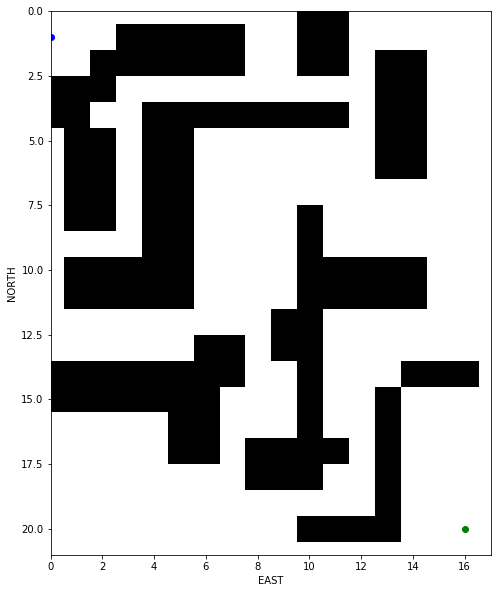

In [18]:
# Print the grid
draw_grid(grid, start = start, goal = goal)

## Heuristics
The heuristic function determines the $h()$ value for each cell based on the goal cell and the method chosen to determine it. The heuristic value can be the Euclidean distance between these cells $h= \left((x_i-x_{goal})^2+(y_i-y_{goal})^2\right)^{1/2}$ or the "Manhattan distance", which is the minimum number of moves required to reach the goal from the assigned cell $h = ||x_i-x_{goal}|| + ||y_i-y_{goal}||$. For this exercise you could use either, or something else which is *admissible* and *consistent*.

The input variables include
* **```position```** the coordinates of the cell for which you would like to determine the heuristic value.
* **```goal_position```** the coordinates of the goal cell

In [19]:
# TODO: implement a heuristic function. This may be one of the
# functions described above or feel free something to think of something
# else.
def heuristic(position, goal_position):
    (px, py) = position
    (gx, gy) = goal_position
    # euclidean distance
    h = (np.linalg.norm(np.array(position) - np.array(goal_position)))
    # manhattan distance
    h += np.abs(px - gx) + np.abs(py - gy)
    return h

## A* search

A* search is an extension of the cost search you implemented. A heuristic function is used in addition to the cost penalty. Thus if the setup is:

* $c$ is the current cost
* $g$ is the cost function
* $h$ is the heuristic function

Then the new cost is $c_{new} = c + g() + h()$.

The difference between $g$ and $h$ is that $g$ models the cost of performing actions, irrespective of the environment, while $h$ models the cost based on the environment, i.e., the distance to the goal.

You know what comes next, turn the `TODOs` into `DONEs` :)

In [20]:
def a_star(grid, h, start, goal):

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                # get the tuple representation
                da = action.delta
                cost = action.cost
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                # TODO: calculate new cost, c + g() + h()
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (current_cost + cost, current_node, action)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][2])
            n = branch[n][1]
        path.append(branch[n][2])
            
    return path[::-1], path_cost

In [21]:
import time
t0 = time.time()

path, cost = a_star(grid, heuristic, start, goal)

print('Search took {0} seconds'.format(time.time()-t0))
print(path, cost)

Found a path.
Search took 0.042003631591796875 seconds
[<Action.DOWN_RIGHT: (1, 1, 1.4142135623730951)>, <Action.UP_RIGHT: (-1, 1, 1.4142135623730951)>, <Action.UP_RIGHT: (-1, 1, 1.4142135623730951)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.RIGHT: (0, 1, 1)>, <Action.DOWN_RIGHT: (1, 1, 1.4142135623730951)>, <Action.DOWN_RIGHT: (1, 1, 1.4142135623730951)>, <Action.DOWN_RIGHT: (1, 1, 1.4142135623730951)>, <Action.RIGHT: (0, 1, 1)>, <Action.DOWN_RIGHT: (1, 1, 1.4142135623730951)>, <Action.DOWN: (1, 0, 1)>, <Action.DOWN: (1, 0, 1)>, <Action.DOWN_RIGHT: (1, 1, 1.4142135623730951)>, <Action.DOWN_RIGHT: (1, 1, 1.4142135623730951)>, <Action.DOWN_RIGHT: (1, 1, 1.4142135623730951)>, <Action.DOWN_RIGHT: (1, 1, 1.4142135623730951)>, <Action.DOWN: (1, 0, 1)>, <Action.DOWN_LEFT: (1, -1, 1.4142135623730951)>, <Action.DOWN_LEFT: (1, -1, 1.4142135623730951)>, <Action.DOWN_LEFT: (1, -1, 1.4142135623730951)>, <Action.DOWN_RIGHT: (1, 1, 1.4142135623730951)>

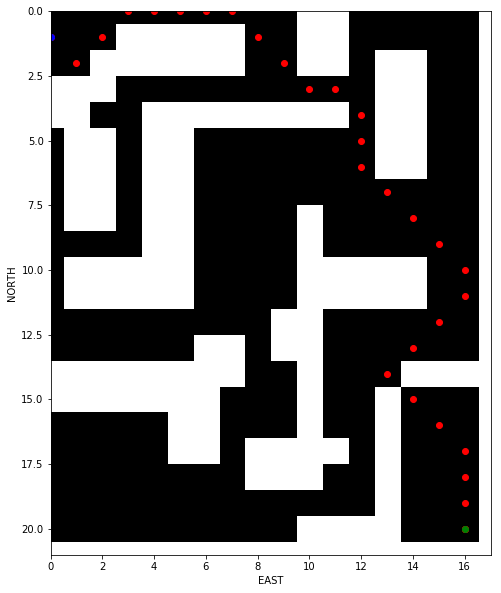

In [22]:
# S -> start, G -> goal, O -> obstacle
original = walkpath(grid, path, start, goal)
draw_grid(grid, cmap = 'gray', path = original, start = start, goal = goal)